# Avro serialization example for postage stamps
This notebook uses python3.  No dependence on lsst stack.

In [1]:
#!pip install avro-python3 

In [2]:
import io
import avro.schema
import avro.io

In [3]:
def write_avro_data(json, avro_schema):
    """Encode json into avro format given a schema.
    """
    writer = avro.io.DatumWriter(avro_schema)
    bytes_io = io.BytesIO()
    encoder = avro.io.BinaryEncoder(bytes_io)
    writer.write(json, encoder)
    return bytes_io


def read_avro_data(bytes_io, avro_schema):
    """Read avro data and decode with a given schema.
    """
    raw_bytes = bytes_io.getvalue()
    bytes_reader = io.BytesIO(raw_bytes)
    decoder = avro.io.BinaryDecoder(bytes_reader)
    reader = avro.io.DatumReader(avro_schema)
    message = reader.read(decoder)
    return message


### Create Avro schema for postage stamp.

In [4]:
stamp_schema = '''
{
"namespace": "lsst.alert",
 "type": "record",
 "name": "stamp",
 "fields": [
     {"name": "filename", "type": "string"},
     {"name": "stampdata", "type": "bytes"}
     ]
}
'''

schema = avro.schema.Parse(stamp_schema)

In [5]:
print(schema)

{"type": "record", "namespace": "lsst.alert", "fields": [{"type": "string", "name": "filename"}, {"type": "bytes", "name": "stampdata"}], "name": "stamp"}


### Read in .fits file to send as postage stamp.

In [6]:
# Stamps of various sizes, e.g. below, should be able to be transmitted. 
#stampfile = 'stamp-40320.fits'
#stampfile = 'stamp-48960.fits'
stampfile = 'stamp-54720.fits'

with open(stampfile, mode='rb') as file: # b is important -> binary
    stamp = file.read()
    
print(type(stamp))

<class 'bytes'>


Put stamp data into format for schema.  We can use the value of filename to identify the stamp and the intended format for the receiver.

In [7]:
test_data = {"filename": "stamp-someid.fits", "stampdata": stamp}

### Write to Avro format.

In [8]:
avro_data = write_avro_data(test_data, schema)

### Read from Avro format.
Mimics collecting the stamp from alert distribution system.

In [9]:
collected_stamp = read_avro_data(avro_data, schema)

Write out collected stamp to local filesystem, using filename value. 

In [10]:
with open(collected_stamp['filename'], mode='wb') as file:
    file.write(collected_stamp['stampdata'])

### Read and plot the collected stamp file

Filename: stamp-someid.fits
No.    Name         Type      Cards   Dimensions   Format
0    IMAGE       PrimaryHDU      35   (51, 43)     float32   
1    MASK        ImageHDU        38   (51, 43)     int16 (rescales to uint16)   
2    VARIANCE    ImageHDU        36   (51, 43)     float32   
3    PSF         ImageHDU         9   (31, 31)     float64   


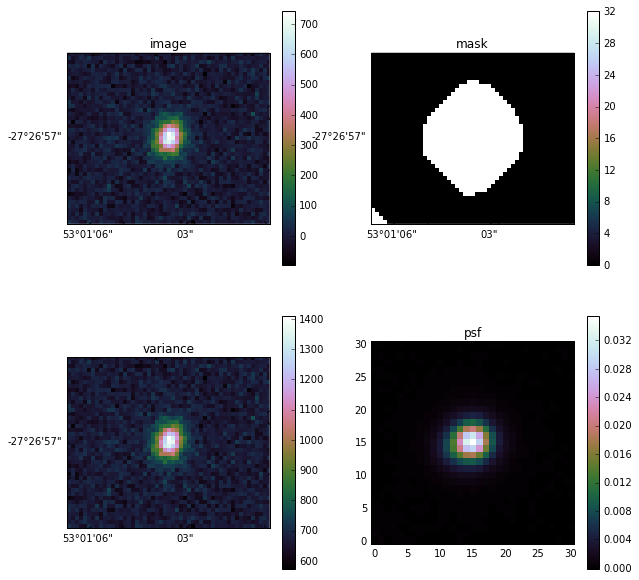

In [11]:
#!pip install wcsaxes #for WCS plotting projection
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.wcs import WCS

collected_file = collected_stamp['filename']
fits.info(collected_file)

with fits.open(collected_file) as hdu:
    im_wcs = WCS(hdu[0].header)
    mask_wcs = WCS(hdu[1].header)
    var_wcs = WCS(hdu[2].header)
    
image_data = fits.getdata(collected_file, ext=0)
mask_data = fits.getdata(collected_file, ext=1)
var_data = fits.getdata(collected_file, ext=2)
psf_data = fits.getdata(collected_file, ext=3)

fig = plt.figure(figsize=(10,10))
settings = dict(cmap='cubehelix', interpolation='nearest', origin='lower')

# image
fig.add_subplot(221, projection=im_wcs)
plt.title('image')
plt.imshow(image_data, **settings)
plt.colorbar()

# mask
fig.add_subplot(222, projection=mask_wcs)
plt.title('mask')
plt.imshow(mask_data, **settings)
plt.colorbar()

# variance
fig.add_subplot(223, projection=var_wcs)
plt.title('variance')
plt.imshow(var_data, **settings)
plt.colorbar()

# psf
plt.subplot(224)
plt.title('psf')
plt.imshow(psf_data, **settings)
plt.colorbar()
